In [ ]:
import pandas as pd
df_y=pd.read_csv('amino.csv')
# df_y=df_y["Exp. % MGS"]
glyco2 = pd.read_csv('glyco2.csv')
df_y.head()

,Name,SMILES,Concentration (mM),Exp. % MGS,Exp. error,Set
0,l-alpha-alanine,C[C@@H](C(=O)O)N,20,54.4,17.3,train/test
1,l-valine,N[C@H](C(=O)O)C(C)C,20,44.5,7.8,train/test
2,l-leucine,CC(C)C[C@@H](C(=O)O)N,20,45.6,14.0,train/test
3,l-isoleucine,CC[C@H](C)[C@@H](C(=O)O)N,20,18.8,4.1,train/test
4,l-proline,C1C[C@H](NC1)C(=O)O,20,102.8,15.6,train/test


In [ ]:
clq_amino=pd.read_csv('clq_amino.csv')
clq_glyco2 = pd.read_csv('clq_glyco2.csv')
hydhist_amino=pd.read_csv('hydhist_amino.csv')
hydhist_glyco2 = pd.read_csv('hydhist_glyco2.csv')
hydidx_amino=pd.read_csv('hydidx_amino.csv')
hydidx_glyco2 = pd.read_csv('hydidx_glyco2.csv')
soaps_amino=pd.read_csv('soaps_amino.csv')
# soaps_glyco2 = pd.read_csv('soaps_glyco2.csv')
std_amino=pd.read_csv('std_amino.csv')
std_glyco2 = pd.read_csv('std_glyco2.csv')
wacsf_amino=pd.read_csv('wacsf_amino.csv')
wacsf_glyco2 = pd.read_csv('wacsf_glyco2.csv')

In [ ]:
clq_amino = clq_amino.iloc[:, 1:]
hydhist_amino = hydhist_amino.iloc[:, 1:]
hydidx_amino = hydidx_amino.iloc[:, 1:]
soaps_amino = soaps_amino.iloc[:, 1:]
df_X = std_amino.iloc[:, 1:]
wacsf_amino = wacsf_amino.iloc[:, 1:]

In [ ]:
clq_amino.shape, hydhist_amino.shape, hydidx_amino.shape, soaps_amino.shape, df_X.shape, wacsf_amino.shape

((60, 24), (60, 100), (60, 10), (60, 1051), (60, 45), (60, 280))

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from keras.optimizers import Adagrad,Nadam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [ ]:
def create_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(60, activation='relu')(inputs)
    x = Dense(60, activation='relu')(x)
    x = Dense(60, activation='relu')(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Nadam(), loss='mse',)
    return model

In [ ]:
df = pd.concat([df_X, df_y['Exp. % MGS']], axis=1)

predictions = pd.DataFrame(index=df.index, columns=['Actual', 'Predicted'])

scaler = StandardScaler()
features = df_X.columns

In [ ]:
for i in range(len(df)):
    # Prepare the training and test sets
    test_row = df.iloc[i:i+1]
    train_rows = df.drop(i)

    # Normalize the training data
    X_train = scaler.fit_transform(train_rows[features])
    y_train = train_rows["Exp. % MGS"].values

    # Normalize the test data
    X_test = scaler.transform(test_row[features])
    y_test = test_row["Exp. % MGS"].values

    # Create and train the model
    model = create_model(input_shape=X_train.shape[1])
    model.fit(X_train, y_train, epochs=135, verbose=1,batch_size=10)

    # Predict the value for the test set row
    y_pred = model.predict(X_test)[0][0]

    # Store the actual and predicted values
    predictions.at[i, 'Actual'] = y_test[0]
    predictions.at[i, 'Predicted'] = y_pred

# Display the predictions DataFrame
print(predictions)

Streaming output truncated to the last 5000 lines.
Epoch 106/135
6/6 [==============================] - 0s 5ms/step - loss: 21.5157
Epoch 107/135
6/6 [==============================] - 0s 4ms/step - loss: 20.5774
Epoch 108/135
6/6 [==============================] - 0s 3ms/step - loss: 19.8266
Epoch 109/135
6/6 [==============================] - 0s 4ms/step - loss: 19.4209
Epoch 110/135
6/6 [==============================] - 0s 3ms/step - loss: 19.0711
Epoch 111/135
6/6 [==============================] - 0s 3ms/step - loss: 17.6116
Epoch 112/135
6/6 [==============================] - 0s 4ms/step - loss: 18.2474
Epoch 113/135
6/6 [==============================] - 0s 3ms/step - loss: 17.5607
Epoch 114/135
6/6 [==============================] - 0s 3ms/step - loss: 16.7201
Epoch 115/135
6/6 [==============================] - 0s 3ms/step - loss: 15.5580
Epoch 116/135
6/6 [==============================] - 0s 3ms/step - loss: 15.5005
Epoch 117/135
6/6 [==============================] - 0s 3m

In [4]:
mse = mean_squared_error(predictions['Actual'], predictions['Predicted'])
pcc, _ = pearsonr(predictions['Actual'], predictions['Predicted'])
mse, pcc

(349.16568602481595, 0.786000777624193)

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 3.1 MB/s eta 0:00:00


In [ ]:
import shap

In [ ]:
X = df_X.values
# masker = shap.maskers.Independent(data=X)
explainer = shap.KernelExplainer(model_std,X)
shap_values = explainer.shap_values(X)

  0%|          | 0/60 [00:00<?, ?it/s]

In [ ]:
shap_values = np.reshape(shap_values, (60, 45))
np.shape(shap_values.data)

(60, 45)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[21])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:,:5])

In [ ]:
explainer.expected_value

array([54.81330535])

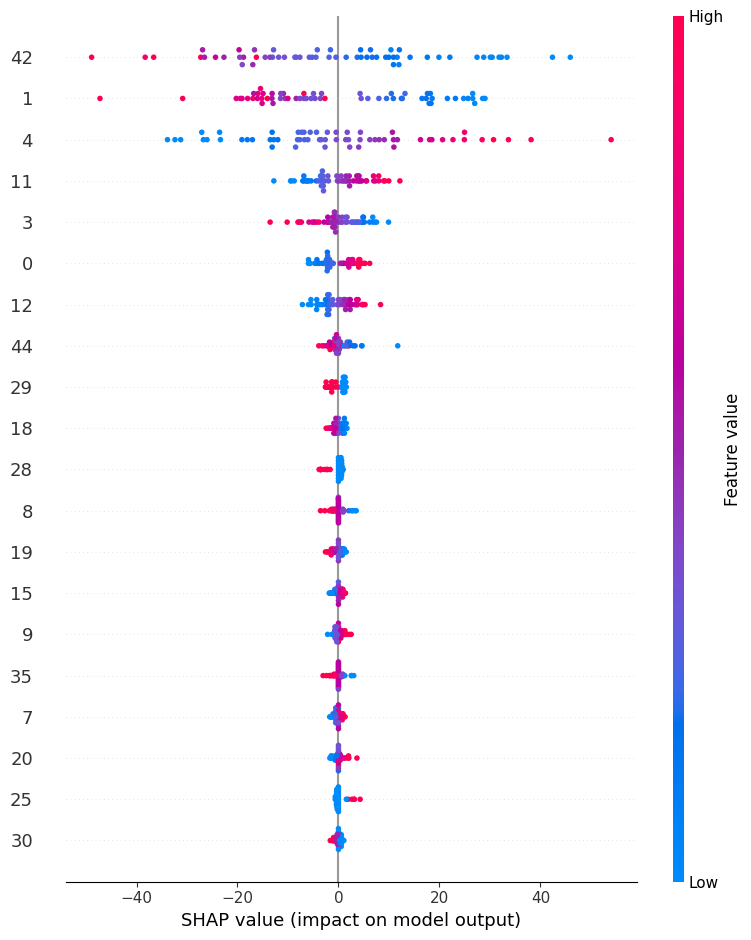

In [ ]:
exp = shap.Explanation(shap_values, data = X, feature_names=df_X.columns)
shap.summary_plot(exp)

In [ ]:
shap_df = pd.DataFrame(shap_values)
shap_df.shape

(60, 45)

In [ ]:
shap_df

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,0.624833,26.589904,0.355266,2.565095,-32.381311,0.810102,0.000000,0.269219,0.000000,-0.620948,...,0.000000,0.184059,0.240901,0.000000,0.000000,0.000000,0.000000,33.393818,0.559340,0.155350
1,4.058532,9.529047,0.163169,0.734811,-17.041787,0.087965,0.000000,0.856139,0.000000,-0.602739,...,0.076281,0.314469,0.000000,0.000000,0.000000,-0.508958,0.000000,5.643999,0.000000,-0.748360
2,4.622136,-3.570122,0.293971,-0.416328,-6.835324,0.173500,0.000000,0.779691,-0.146604,-0.613715,...,0.089017,0.342183,0.000000,0.063920,0.000000,-0.287999,0.268509,-8.374102,0.306569,-0.833238
3,5.276654,-4.638669,0.311833,-0.568984,-8.485570,0.183528,0.000000,1.002279,0.000000,-0.547211,...,0.000000,0.437922,0.000000,0.000000,-0.258747,-0.369207,-0.475038,3.719467,-0.318383,-0.715702
4,-4.262206,12.657447,0.468516,3.095929,-19.122535,0.176311,0.000000,0.732384,1.090021,-0.671190,...,0.870084,-0.600790,-0.445646,0.000000,5.315560,4.267756,0.112933,27.448523,0.328552,1.723427
5,2.825292,5.825341,0.618651,0.730836,6.217695,0.628273,0.000000,0.777472,0.096618,-0.540576,...,0.000000,0.507726,-0.239016,0.000000,0.000000,-0.415005,0.253605,-1.588968,0.236548,-0.562487
6,-1.997471,-14.935766,-0.238248,-0.737363,10.694485,-0.193428,0.000000,-0.575718,-0.118862,-0.301255,...,0.000000,-0.320715,0.000000,0.000000,-0.072191,-0.174335,0.000000,-16.629520,0.000000,-0.141241
7,2.684870,17.969379,0.000000,4.906190,-13.130170,0.713607,0.000000,0.611094,-0.812070,0.484336,...,-0.814138,0.263702,0.000000,0.000000,0.000000,-0.250391,0.000000,9.979749,0.120682,-0.454874
8,0.909614,26.603744,0.186141,6.176863,-23.543482,0.960258,0.000000,0.273314,-1.075872,0.511135,...,-0.893959,0.277946,0.090109,0.000000,0.000000,0.000000,0.000000,30.451973,0.318468,-2.302872
9,1.095065,29.030820,0.609754,3.600958,-12.020182,0.917597,0.000000,0.442096,0.000000,-0.687610,...,0.000000,0.436954,0.000000,0.000000,0.000000,-0.388173,0.000000,32.286997,0.000000,1.266407


In [ ]:
mod_sum=shap_df.abs().sum()/60
mod_sum = pd.DataFrame(mod_sum, columns=['weight'])
mod_sum['Property'] = [f'Property {i+1}' for i in range(shap_df.shape[1])]
mod_sum = mod_sum[['Property', 'weight']]
print(mod_sum)

       Property     weight
0    Property 1   2.880395
1    Property 2  14.984190
2    Property 3   0.331797
3    Property 4   3.535996
4    Property 5  14.227747
5    Property 6   0.360798
6    Property 7   0.023069
7    Property 8   0.622751
8    Property 9   0.770654
9   Property 10   0.691675
10  Property 11   0.118241
11  Property 12   4.623804
12  Property 13   2.663483
13  Property 14   0.075241
14  Property 15   0.048898
15  Property 16   0.704958
16  Property 17   0.196706
17  Property 18   0.029083
18  Property 19   0.967494
19  Property 20   0.714091
20  Property 21   0.578284
21  Property 22   0.200325
22  Property 23   0.066846
23  Property 24   0.078786
24  Property 25   0.158291
25  Property 26   0.494015
26  Property 27   0.148001
27  Property 28   0.072742
28  Property 29   0.829944
29  Property 30   1.273111
30  Property 31   0.487236
31  Property 32   0.262503
32  Property 33   0.084056
33  Property 34   0.230501
34  Property 35   0.108302
35  Property 36   0.624041
3

<BarContainer object of 45 artists>

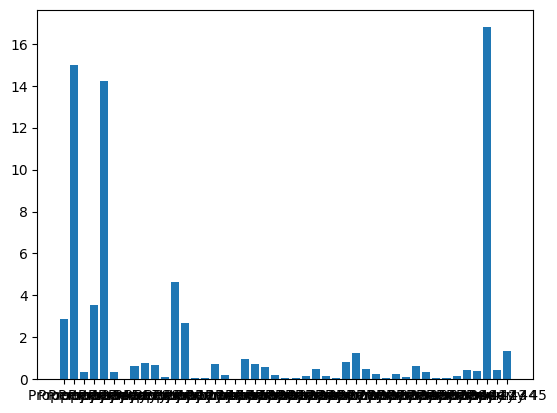

In [ ]:
plt.bar(mod_sum['Property'], mod_sum['weight'])

In [ ]:
indexes = mod_sum.index[mod_sum['weight'] <= 1].tolist()

columns = df_X.columns[indexes]
df_get = df_X.drop(columns=columns)

df_get.shape

(60, 9)

In [ ]:
df = pd.concat([df_get, df_y['Exp. % MGS']], axis=1)

predictions = pd.DataFrame(index=df.index, columns=['Actual', 'Predicted'])

scaler = StandardScaler()
features = df_get.columns

for i in range(len(df)):
    # Prepare the training and test sets
    test_row = df.iloc[i:i+1]
    train_rows = df.drop(i)

    # Normalize the training data
    X_train = scaler.fit_transform(train_rows[features])
    y_train = train_rows["Exp. % MGS"].values

    # Normalize the test data
    X_test = scaler.transform(test_row[features])
    y_test = test_row["Exp. % MGS"].values

    # Create and train the model
    model = create_model(input_shape=X_train.shape[1])
    model.fit(X_train, y_train, epochs=135, verbose=1,batch_size=10)

    # Predict the value for the test set row
    y_pred = model.predict(X_test)[0][0]

    # Store the actual and predicted values
    predictions.at[i, 'Actual'] = y_test[0]
    predictions.at[i, 'Predicted'] = y_pred

# Display the predictions DataFrame
print(predictions)

Streaming output truncated to the last 5000 lines.
Epoch 106/135
6/6 [==============================] - 0s 4ms/step - loss: 277.6542
Epoch 107/135
6/6 [==============================] - 0s 4ms/step - loss: 264.2563
Epoch 108/135
6/6 [==============================] - 0s 4ms/step - loss: 269.3088
Epoch 109/135
6/6 [==============================] - 0s 4ms/step - loss: 263.0096
Epoch 110/135
6/6 [==============================] - 0s 4ms/step - loss: 269.2156
Epoch 111/135
6/6 [==============================] - 0s 4ms/step - loss: 261.0250
Epoch 112/135
6/6 [==============================] - 0s 4ms/step - loss: 259.9922
Epoch 113/135
6/6 [==============================] - 0s 4ms/step - loss: 257.6343
Epoch 114/135
6/6 [==============================] - 0s 5ms/step - loss: 256.9320
Epoch 115/135
6/6 [==============================] - 0s 5ms/step - loss: 254.5179
Epoch 116/135
6/6 [==============================] - 0s 5ms/step - loss: 254.9806
Epoch 117/135
6/6 [============================

In [2]:
rmse = np.sqrt(mean_squared_error(predictions['Actual'], predictions['Predicted']))
pcc, _ = pearsonr(predictions['Actual'], predictions['Predicted'])
rmse, pcc

(14.266209962493015, 0.9097694952089036)